In [36]:
# module import
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

# _1_. 데이터 

- 정규분포로부터 데이터 1000개 샘플링.
- 샘플링 후 reshape : 2차원으로 만듦.

In [39]:
# 정규분포로부터 데이터 샘플링
real_data = np.random.normal(size=1000).astype('f') # (1000, )
print(real_data)
real_data = real_data.reshape(real_data.shape[0], 1) # (1000, 1) 2차원으로
print(real_data)
print(real_data.shape)

[-3.14488959e+00  7.55743265e-01  1.01949418e+00 -4.41362292e-01
 -2.39729786e+00 -8.54267180e-01 -9.21691656e-01  1.41111705e-02
 -2.58173323e+00  5.02675891e-01 -1.99124086e+00  7.86180913e-01
 -3.61121409e-02 -1.06733465e+00 -1.38763750e+00 -1.92161024e+00
 -5.61605275e-01  9.96780321e-02 -6.45744681e-01  8.86945426e-02
 -1.35516572e+00  9.57718372e-01  3.04199010e-01 -3.31303984e-01
 -1.85015544e-01 -9.29415703e-01 -5.74518554e-02  8.59562814e-01
 -5.15134454e-01  4.00881499e-01  6.95424080e-01 -2.70214006e-02
  2.37861133e+00 -1.78304887e+00  3.18095177e-01 -8.40476692e-01
 -1.89645433e+00 -1.66603649e+00 -5.03724754e-01 -2.31689787e+00
 -4.54494596e-01  6.78174496e-01  7.86848307e-01  7.25243509e-01
 -5.05148113e-01  1.30506158e-02  1.26518452e+00  4.00673926e-01
 -4.57392246e-01  9.07091498e-02 -1.01650143e+00  3.96243840e-01
  5.61928272e-01  8.78161788e-02 -1.07424748e+00 -2.14996278e-01
  1.25928390e+00 -2.18817115e+00 -1.91947687e+00 -8.10569584e-01
 -3.64954978e-01  4.27276

* 미니 배치 업데이트를 위해 배치 dataset 생성

In [4]:
# batch_DS = tf.data.Dataset.from_tensor_slices(real_data) # Dataset 슬라이스로 생성
# batch_DS = batch_DS.shuffle(buffer_size=real_data.shape[0]) # shuffle
# batch_DS = batch_DS.batch(batch_size = 300) # 300개씩 생성
# batch_DS

<BatchDataset shapes: (None, 1), types: tf.float32>

In [41]:
# mini-batch 업데이트: 300개
batch_data = tf.data.Dataset.from_tensor_slices(real_data)\
               .shuffle(buffer_size=real_data.shape[0])\
               .batch(batch_size=300)
print(batch_data)

<BatchDataset shapes: (None, 1), types: tf.float32>


# _2_. 함수

## KL Divergence 계산
* `np.histogram`
    ```
    Returns
    histarray
    The values of the histogram. See density and weights for a description of the possible semantics.

    bin_edgesarray of dtype float
    Return the bin edges (length(hist)+1).
    ```

    - pdf로 만들기 위해 normalize 왜?
    - pdf로 만들 때 1e-8 왜?

In [59]:
# 두 분포 사이의 KL divergence 계산
def calc_KL(P, Q):
    '''
    params 
        P : 확률분포
        Q : P를 모사한 확률분포
    return : P, Q의 히스토그램, kldivergence 수치
    '''
    hist_P, bins_P = np.histogram(P, bins=50)
    hist_Q, bins_Q = np.histogram(Q, bins=bins_P) # P 분포 히스토그램의 간격과 같게 히스토그램 생성

    # pdf로 만들기 위해 normalize????????????????
    hist_P = hist_P / (np.sum(hist_P) + 1e-8) # 분모가 0이 되는 것을 방지
    hist_Q = hist_Q / (np.sum(hist_Q) + 1e-8)

    # KL Divergence 계산: 말 그대로 식 옮겨온 것.
    kld = np.sum( hist_P * (np.log(hist_P + 1e-8) - np.log(hist_Q + 1e-8)) )

    return hist_P, hist_Q, kld

## clip 기능
* log 안에 0 들어가는 것 방지

In [6]:
def myLog(x):
    '''
    params
        x : clipping할 log값
    return : 1e-8 더해서 clip한 log값
    '''
    return tf.math.log(x + 1e-8)

# _3_. 모델 가중치, bias 설정.

## Discriminator Network
- 각각 hidden, output에 대한 W, b.
- 각각의 노드 수 설정하되, output은 1이어야 함. 맞는지 아닌지 판별.

In [60]:
# Discriminator 파라미터
d_input = real_data.shape[1] # 인풋 노드 수
d_hidden = 8
d_output = 1 # 주의: 0 아니면 1로 나온다.

# Discriminator 레이어 설정
d_Wh = tf.Variable(tf.random.normal([d_input, d_hidden]), name='D_Wh')
d_Bh = tf.Variable(tf.random.normal([d_hidden]), name='D_Bh')
d_Wo = tf.Variable(tf.random.normal([d_hidden, d_output]), name='D_Wo')
d_Bo = tf.Variable(tf.random.normal([d_output]), name='D_Bo')

# 가중치 판 번에 묶어 주기
d_theta = [d_Wh, d_Bh, d_Wo, d_Bo]

## Generator Network


- 각각 hidden, output에 대한 W, b.
- 노드 수 설정 주의: g_output 노드 수는 d_input 노드 수와 같아야 함.

In [61]:
# Generator 파라미터
g_input = 8 # 임의 설정
g_hidden = 4 # 임의 설정
g_output = d_input # 주의

# Generator 레이어 설정
g_Wh = tf.Variable(tf.random.normal([g_input, g_hidden]), name='G_Wh')
g_Bh = tf.Variable(tf.random.normal([g_hidden]), name='G_Bh')
g_Wo = tf.Variable(tf.random.normal([g_hidden, g_output]), name='G_Wo')
g_Bo = tf.Variable(tf.random.normal([g_output]), name='G_Bo')

# 가중치 한 번에 묶어 주기
g_theta = [g_Wh, g_Bh, g_Wo, g_Bo]

# _4_. 학습 위한 함수 설정

- Tensorflow: activation 함수 주의.


### Discriminator
* 은닉층 활성화: ReLU
* 출력층: sigmoid

In [62]:
def Discriminator(x):
    d_Ho = tf.nn.relu(tf.matmul(x, d_Wh) + d_Bh) # discriminator 히든 레이어: relu
    d_Out = tf.nn.sigmoid(tf.matmul(d_Ho, d_Wo) + d_Bo) # 0과 1사이로 출력하니까: sigmoid
    return d_Out

### Generator
* 출력층 활성화 함수 없음. 그 자체로 다시 Discriminator에 넣어서 D(G(z))로 활용하기 때문.

In [63]:
def Generator(z):
    g_Ho = tf.nn.relu(tf.matmul(z, g_Wh) + g_Bh)
    g_Out = tf.matmul(g_Ho, g_Wo) + g_Bo
    return g_Out

### getNoise
- 정규분포를 따르는 데이터 생성해 냄.

In [64]:
def getNoise(m, n = g_input):
    z = np.random.uniform(-1.0, 1.0, size=[m, n]).astype('f')
    return z

### Discriminator Loss
- loss function 말 그대로 구현
- 계산 편의 상 (-) 붙여서 minimize하도록.
- 로그 값 클리핑 들어 감.

In [65]:
def lossD(x, z):
    Dx = Discriminator(x) # 진짜 데이터 x에 대해 discriminator가 판별.
    
    Gz = Generator(z) # generator가 만들어 낸 데이터
    DGz = Discriminator(Gz) # 제너레이터가 만든 데이터를 discriminator가 판별.
    
    return -tf.reduce_mean(myLog(Dx) + myLog(1-DGz)) # minimize로 바꿔 줌.

### Generator Loss
* loss function 말 그대로 구현
* x term과 무관
* 로그 값 클리핑 들어 감.

In [66]:
def lossG(z):
    Gz = Generator(z)
    DGz = Discriminator(Gz)
    
    return tf.reduce_mean(myLog(1-DGz))

# _5_. 학습

In [67]:
# optimizer 설정
adam = Adam(learning_rate=0.0005)

Epoch: 0, D-Loss: 1.3854079246520996, G-Loss: -0.6944909691810608, KL-Divergence: 2.1718382145220803
Epoch: 10, D-Loss: 1.3876593112945557, G-Loss: -0.6921648979187012, KL-Divergence: 1.2685679425736032
Epoch: 20, D-Loss: 1.391505479812622, G-Loss: -0.6952455043792725, KL-Divergence: 1.8839142426028228
Epoch: 30, D-Loss: 1.3826420307159424, G-Loss: -0.6909218430519104, KL-Divergence: 1.4518143569862074
Epoch: 40, D-Loss: 1.3871874809265137, G-Loss: -0.6921681761741638, KL-Divergence: 1.5353908895051986
Epoch: 50, D-Loss: 1.3842253684997559, G-Loss: -0.6918429732322693, KL-Divergence: 1.1892653153128387
Epoch: 60, D-Loss: 1.3844146728515625, G-Loss: -0.6932619214057922, KL-Divergence: 2.134779650028068
Epoch: 70, D-Loss: 1.3832151889801025, G-Loss: -0.692690372467041, KL-Divergence: 3.515453484039529
Epoch: 80, D-Loss: 1.382362723350525, G-Loss: -0.6884827613830566, KL-Divergence: 2.5762695125332438
Epoch: 90, D-Loss: 1.3852061033248901, G-Loss: -0.6933408379554749, KL-Divergence: 2.372

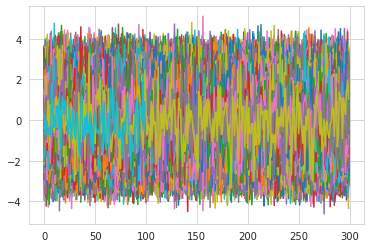

In [89]:
# 학습
loss_D = [] # Discriminator loss history
loss_G = [] # Generator loss history
KL = [] # KL Divergence history

# 3000번 학습
for i in range(3000):

    for batch_X in batch_data: # 미니배치 단위로 밀어 넣음.

        batch_Z = getNoise(m=batch_X.shape[0], n=g_input) # 가짜 데이터 미니배치 단위로 생성.

        # Discriminator 먼저 학습: 진짜 x 데이터와 z 데이터 가지고.
        adam.minimize(lambda: lossD(batch_X, batch_Z), var_list=d_theta)
        # Generator 학습: 가짜 데이터로 만든 loss 최소화되도록.
        adam.minimize(lambda: lossG(batch_Z), var_list=g_theta)
    
    # 10번 학습할 때마다 loss, KL history 보관
    if i % 10 == 0:
        p, q, kld = calc_KL(batch_X, Generator(batch_Z))
        KL.append(kld)
        loss_D.append(lossD(batch_X, batch_Z))
        loss_G.append(lossG(batch_Z))

        print(f"Epoch: {i}, D-Loss: {loss_D[-1]}, G-Loss: {loss_G[-1]}, KL-Divergence: {KL[-1]}")

# _6_. 그림

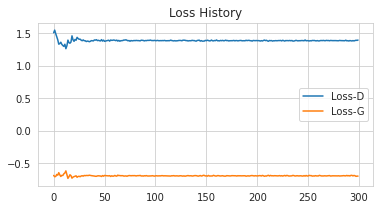

In [69]:
# discriminator, generator loss
plt.figure(figsize=(6, 3))
plt.plot(loss_D, label='Loss-D')
plt.plot(loss_G, label='Loss-G')
plt.legend()
plt.title('Loss History')
plt.show()

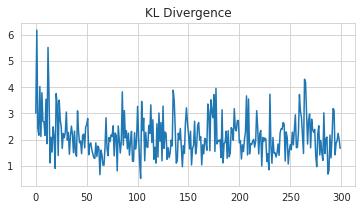

In [70]:
# kl divergence
plt.figure(figsize=(6,3))
plt.plot(KL)
plt.title("KL Divergence")
plt.show()

데이터 2차원이었으므로, 인덱싱할 때 `[:, 0]`으로 한다!

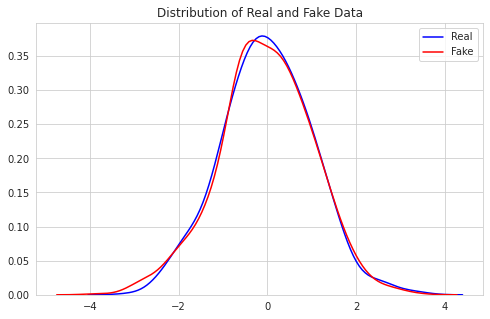

In [71]:
# real data(P)와 fake data(Q)의 분포
z = getNoise(m=real_data.shape[0], n=g_input)
fake_data = Generator(z).numpy() # fake data로 넣음

plt.figure(figsize=(8, 5))
sns.set_style('whitegrid')
sns.kdeplot(real_data[:, 0], color='blue', bw=0.3, label='Real') # kde?????????????????
sns.kdeplot(fake_data[:, 0], color='red', bw=0.3, label='Fake')
plt.legend()
plt.title('Distribution of Real and Fake Data')
plt.show()

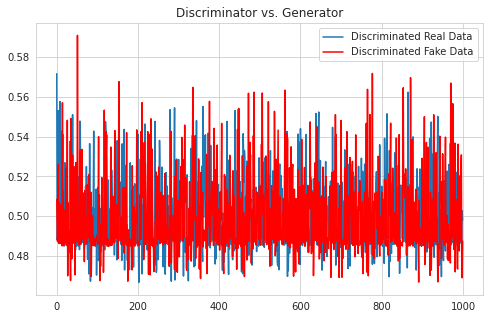

In [86]:
# 학습 완료 후 real data를 넣어 보자.
DGz_real_values = Discriminator(real_data)
DGz_fake_values = Discriminator(fake_data)

plt.figure(figsize=(8, 5))
plt.plot(DGz_real_values, label='Discriminated Real Data')
plt.plot(DGz_fake_values, label='Discriminated Fake Data', color='red')
plt.title("Discriminator vs. Generator")
plt.legend()
plt.show()

## ====== 테스트 ========

[ 9 18 29 60 59 56 44 17  5  3] [-2.4535491  -1.9274077  -1.4012663  -0.87512493 -0.34898353  0.17715788
  0.7032993   1.2294407   1.7555821   2.2817235   2.807865  ]
[0.03       0.06       0.09666667 0.2        0.19666667 0.18666667
 0.14666667 0.05666667 0.01666667 0.01      ]


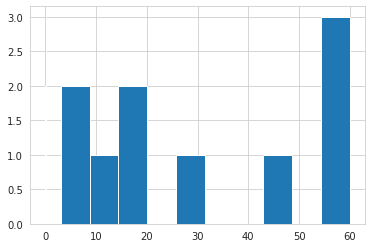

In [58]:
for batch_X in batch_data:
    hist_P, bins_P = np.histogram(batch_X)
    print(hist_P, bins_P)
    plt.hist(hist_P)
    print(hist_P / np.sum(hist_P))
    plt.hist(hist_P / np.sum(hist_P))
    plt.show()
    break